# MMR Predictor
Predicting MMR of a *League of Legends* match using Recurrent Neural Network model

In [105]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math
from typing import Dict, List
from torch.utils.data import Dataset, DataLoader

## Data Processing

In [106]:
def calculate_avg_mmr(elo_ratings):
    """
    Calculate the average value of 10 players' ELO ratings.
    Return -1 if the avg is out of bounds (0 - 3386)
    """
    ret = math.floor(sum(elo_ratings)/len(elo_ratings))
    if ret < 0 or ret > 3386:
        return -1
    
    return ret
def classify_elo(elo):
    """
    Return the index representing a ranking system in League of Legends.
    
    Iron IV, III, II, I = 0, 1, 2, 3
    Bronze IV, III, II, I = 4, 5, 6, 7
    Silver IV, III, II, I = 8, 9, 10, 11
    Gold IV, III, II, I = 12, 13, 14, 15
    Platinum IV, III, II, I = 16, 17, 18, 19
    Diamond IV, III, II, I = 20, 21, 22, 23
    Master = 24
    Grandmaster = 25
    Challengers = 26
    """
    mmr_ranges = [
        [0, 112], [112, 227], [227, 479], [497, 579], # Iron
        [579, 757], [757, 963], [963, 1094], [1094, 1207], # Bronze
        [1207, 1308], [1308, 1418], [1418, 1528], [1528, 1619], # Silver
        [1619, 1702], [1702, 1793], [1793, 1896], [1896, 1980], # Gold
        [1980, 2045], [2045, 2146], [2146, 2255], [2255, 2329], # Platinum
        [2329, 2396], [2396, 2487], [2487, 2602], [2602, 2729], # Diamond
        [2729, 2893], # Master
        [2893, 3126], # Grandmaster 
        [3126, 3386] # Challenger
    ]
    for i in range(len(mmr_ranges)):
        if mmr_ranges[i][0] <= elo < mmr_ranges[i][1]:
            return i
    
    return -1 

def process_data():
    """
    # TODO: Add documentation
    """
    data = []
    
    path = os.getcwd() + '\\DataCollection\\data\\'
    matches = os.listdir(path)
    for file_name in matches:
        try:
            with open(path + file_name) as f:
                raw_data = json.load(f)
                if raw_data['timeline'] and raw_data['elo'] and len(raw_data['timeline']) >= 15:
                    avg_mmr = calculate_avg_mmr(raw_data['elo'])
                    if avg_mmr != -1:
                        
                        x = torch.tensor(raw_data['timeline'][:15]) # only take the first 15 minutes
                        data.append((x, classify_elo(avg_mmr)))
        except:
            print(file_name + " failed")
            
    return data


def split_data(data, n_train=600, n_valid=0, n_test=0): # TODO: change values
    return data[:n_train], data[n_train:], []


def data_summary(data):
    data_len = len(data)
    one_dim = data[0][0].size()
    
    s = "-- Data Summary --" + \
        "\nNo. of datapoints = " + str(data_len) + \
        "\nSingle datapoint shape = " + str(one_dim)
    
    return s


In [107]:
data = process_data()
train_data, valid_data, test_data = split_data(data)

.ipynb_checkpoints failed
data.zip failed
data2.zip failed
data3.zip failed
data4.zip failed
NA1_4254389703.json failed
NA1_4257559125.json failed
NA1_4257626867.json failed
NA1_4257780709.json failed
NA1_4258598595.json failed
NA1_4258682289.json failed
NA1_4258717507.json failed
NA1_4259414463.json failed
NA1_4259523663.json failed
NA1_4259567365.json failed
NA1_4259668133.json failed
NA1_4260046572.json failed
NA1_4260518938.json failed
NA1_4260579947.json failed
NA1_4260684262.json failed
NA1_4260758672.json failed
NA1_4260841936.json failed
NA1_4260980761.json failed
NA1_4261015363.json failed
NA1_4261125263.json failed
NA1_4261268956.json failed
NA1_4261306791.json failed
NA1_4261367460.json failed
NA1_4261368109.json failed
NA1_4261387648.json failed
NA1_4261412284.json failed
NA1_4261416389.json failed
NA1_4261418371.json failed
NA1_4261423080.json failed
NA1_4261426488.json failed
NA1_4261428004.json failed
NA1_4261462230.json failed
NA1_4261466568.json failed
NA1_4261467825.j

In [108]:
print(data_summary(data))
print(data[0])

-- Data Summary --
No. of datapoints = 672
Single datapoint shape = torch.Size([15, 50])
(tensor([[  554,   581,   500,     0,     0,   557,   345,   500,     0,     0,
           335,   269,   500,     0,     0,   194,   457,   500,     0,     0,
           329,   650,   500,     0,     0, 14180, 14271,   500,     0,     0,
         14176, 14506,   500,     0,     0, 14398, 14582,   500,     0,     0,
         14539, 14394,   500,     0,     0, 14404, 14201,   500,     0,     0],
        [ 1292, 12240,   500,     0,     0,  6937,  2946,   500,     0,     0,
          8816,  4364,   500,     0,     0, 10490,  3040,   500,     0,     0,
         11669,  3339,   500,     0,     0,  7904,  7803,   500,     0,     0,
         13453, 12892,   500,     0,     0,  4506, 11605,   500,     0,     0,
         12787,  3216,   500,     0,     0, 10880,  4484,   500,     0,     0],
        [ 2622, 12870,   612,   240,    98, 12730,  3172,   683,   404,   233,
          7154,  6855,   584,   240,   

## RNN Model

In [109]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=15, num_classes=27):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  
        # or:
        #out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 10)
        return out



## Training the Model

In [110]:
def plot_training_curves(iters, losses, train_acc):
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Loss")
    plt.plot(iters, train_acc, label="Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Loss/Accuracy")
    plt.legend(["Loss", "Accuracy"])
    plt.show()
    
    



def get_accuracy(model, data):
    """
    #TODO: brief explanation on what correct prediction is
    """
    loader = torch.utils.data.DataLoader(data, batch_size=256, shuffle=True)
    model.eval()
    
    correct = 0
    total = 0
    
    for matches, avg_mmrs in loader:
        matches = matches.type(torch.FloatTensor)
        generated_mmr = model(matches)
        for i in range(len(avg_mmrs)):
#             print(torch.argmax(generated_mmr[i]), (avg_mmrs[i]))
            if torch.argmax(generated_mmr[i]) == (avg_mmrs[i]):
                correct += 1
            total += 1
#     print(correct/total)
    return correct/total



In [111]:
def training(model, train_data, valid_data=None, \
             batch_size=32, \
             weight_decay=0.0, \
             learning_rate=0.001, \
             num_epochs=7, \
             max_iters=1000, \
             checkpoint_path=None, \
             momentum=0.9, \
             save_after=100):
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
    
    # We use Cross-Entropy Loss function and Adam optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    iters, losses, train_acc, val_acc = [], [], [], []
    n = 0
    for epoch in range(num_epochs):
        tacc, vacc = 0, 0
        for matches, avg_mmrs in iter(train_loader):
            if matches.size()[0] < batch_size:
                continue
                
#             print(matches)
#             print(avg_mmrs)
            matches = matches.type(torch.FloatTensor)
#             avg_mmrs = avg_mmrs.type(torch.LongTensor)
            model.train()
#             print(avg_mmrs)
            output = model(matches) # forward pass
        
#             print(output.shape)
#             output = output.type(torch.LongTensor)
#             print(output)
            loss = criterion(output, avg_mmrs)
            loss.backward() # backward pass
            optimizer.step()
            optimizer.zero_grad()
            
            iters.append(n)
            n += 1
            losses.append(float(loss)/batch_size)
            tacc = get_accuracy(model, train_data)
            train_acc.append(tacc)
            
            if valid_data is not None:
                vacc = get_accuracy(model, valid_data)
                val_acc.append(vacc)
        
        print("Epoch %d. [Train Acc %.0f%%] [Val Acc %.0f%%]" % (epoch, tacc * 100, vacc * 100))
        #torch.save(model.state_dict(), checkpoint_path.format(n))
        
    return iters, losses, train_acc, val_acc



In [ ]:
model = RNN(50)
iters, losses, train_acc, val_acc = training(model, train_data, valid_data, batch_size=16, \
             weight_decay=0.0, \
             learning_rate=0.07, \
             num_epochs=20, \
             max_iters=1000, \
             checkpoint_path=None, \
             momentum=0.0, \
             save_after=100) # MODEL NOT FIXED YET

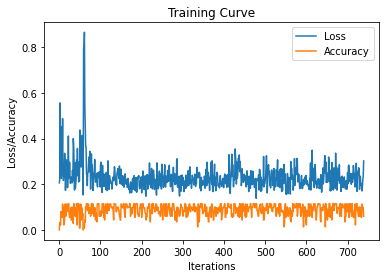

In [104]:
plot_training_curves(iters, losses, train_acc)

In [19]:
#test_accuracy = get_accuracy(model, test_data)

In [21]:
print("-- MMR Predictor Accuracy Results: --")
#print("\nTraining Accuracy: ", train_acc[-1])
#print("\nValidation Accuracy: ", val_acc[-1])
#print("\nTest Accuracy: ", test_accuracy)

-- MMR Predictor Accuracy Results: --
